In [1]:
import numpy as np
from pandas import Series
import seaborn as sns
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
# Read Excel file and convert it to CSV
excel_file = '../../../Data_Thesis/CNS/Data/NCS_recal/PWD_ST11_GOM22SU_recal.XLS'
csv_file = '../../../Data_Thesis/CNS/Data/Areas/GOM22SU_ST.11_PWD.csv'
df = pd.read_excel(excel_file)
df.to_csv(csv_file, index=False, header=False)

# Read CSV file and create a DataFrame
column_names = ['name', 'file', 'date', 'time', 'type', 'wtd', 'Unnamed_1', 'Unnamed_2', 'Unnamed_3','Unnamed_4', 'N_area', 'C_area', 'S_area']  # Replace with your desired column names
df = pd.read_csv(csv_file, names=column_names)

# Now you can work with the DataFrame
CAMP = "GOM22SU" 
STN = "St.11"
TREAT = "PWD"
str_id = 'PWD'

Save_name = '../../../Data_Thesis/CNS/Data/GOM22SU_St.11_PWD.csv'

WARNING *** file size (59818) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [3]:
df

,name,file,date,time,type,wtd,Unnamed_1,Unnamed_2,Unnamed_3,Unnamed_4,N_area,C_area,S_area
0,Tin,DfchA002,08/03/2023,15:00,By-Pass,NaN,NaN,NaN,NaN,NaN,0.000000,2.146928e+04,0.0000
0,Blank,DfchA003,08/03/2023,15:12,Blank,NaN,NaN,NaN,NaN,NaN,0.000000,2.643461e+04,0.0000
0,Blank,DfchA004,08/03/2023,15:24,Blank,NaN,NaN,NaN,NaN,NaN,0.000000,2.443916e+04,0.0000
0,Blank,DfchA005,08/03/2023,15:36,Blank,NaN,NaN,NaN,NaN,NaN,0.000000,2.368916e+04,0.0000
0,BBOT,DfchA006,08/03/2023,15:49,By-Pass,NaN,NaN,NaN,NaN,NaN,109834.203125,1.521676e+06,11628.0000
0,STD_LOW,DfchA007,08/03/2023,16:01,STD,1.254,6.25,0.0,NaN,NaN,249055.734375,5.112488e+06,73962.0000
0,STD_MID,DfchA008,08/03/2023,16:13,STD,2.069,6.25,0.0,NaN,NaN,378400.656250,8.390759e+06,139076.0000
0,STD_HIGH,DfchA009,08/03/2023,16:25,STD,2.936,6.25,0.0,NaN,NaN,523330.000000,1.184748e+07,204933.5000
0,Tin,DfchA010,08/03/2023,16:37,By-Pass,NaN,NaN,NaN,NaN,NaN,0.000000,1.123706e+05,0.0000
0,Blank,DfchA011,08/03/2023,16:49,Blank,NaN,NaN,NaN,NaN,NaN,0.000000,3.140862e+04,0.0000


In [4]:
# Calculate mean for rows where type is blank
blank_rows = df[df['type'] == 'Blank']
mean_values = blank_rows[['C_area', 'N_area', 'S_area']].mean()

# Subtract mean from respective columns and create new rows
df['N_area_bl'] = df['N_area']# - mean_values['N_area']
df['C_area_bl'] = df['C_area']# - mean_values['C_area']
df['S_area_bl'] = df['S_area']# - mean_values['S_area']

In [5]:
# Calculate C N S wights 
std = df[df['type'] == 'STD']

# Subtract mean from respective columns and create new rows
std['N_wtd'] = std['wtd'] * .0652
std['C_wtd'] = std['wtd'] * .725
std['S_wtd'] = std['wtd'] * .0746

std

C:\Users\12532\AppData\Local\Temp\ipykernel_21804\2823902847.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std['N_wtd'] = std['wtd'] * .0652
C:\Users\12532\AppData\Local\Temp\ipykernel_21804\2823902847.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std['C_wtd'] = std['wtd'] * .725
C:\Users\12532\AppData\Local\Temp\ipykernel_21804\2823902847.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,name,file,date,time,type,wtd,Unnamed_1,Unnamed_2,Unnamed_3,Unnamed_4,N_area,C_area,S_area,N_area_bl,C_area_bl,S_area_bl,N_wtd,C_wtd,S_wtd
0,STD_LOW,DfchA007,08/03/2023,16:01,STD,1.254,6.25,0.0,NaN,NaN,249055.734375,5112488.0,73962.0,249055.734375,5112488.0,73962.0,0.081761,0.909150,0.093548
0,STD_MID,DfchA008,08/03/2023,16:13,STD,2.069,6.25,0.0,NaN,NaN,378400.656250,8390759.0,139076.0,378400.656250,8390759.0,139076.0,0.134899,1.500025,0.154347
0,STD_HIGH,DfchA009,08/03/2023,16:25,STD,2.936,6.25,0.0,NaN,NaN,523330.000000,11847478.0,204933.5,523330.000000,11847478.0,204933.5,0.191427,2.128600,0.219026


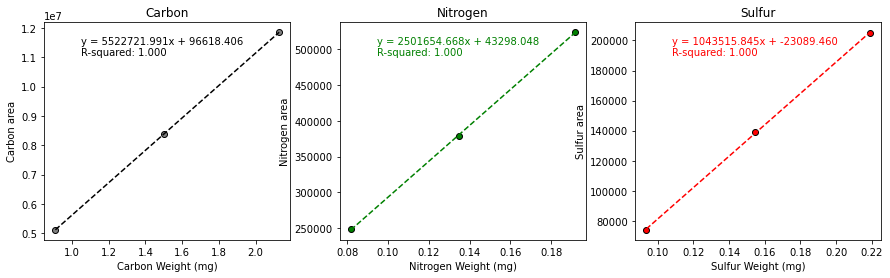

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Scatter plot and linear regression for C_wtd vs C_area
ax = axes[0]
ax.scatter(std['C_wtd'], std['C_area_bl'], facecolor='grey', edgecolor='black')
x = std['C_wtd']
y = std['C_area_bl']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='black', linestyle='--')
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
ax.set_xlabel('Carbon Weight (mg)')
ax.set_ylabel('Carbon area')
ax.set_title('Carbon')
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=10, color='black')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=10, color='black')

# Scatter plot and linear regression for N_wtd vs N_area
ax = axes[1]
ax.scatter(std['N_wtd'], std['N_area_bl'], facecolor='green', edgecolor='black')
x = std['N_wtd']
y = std['N_area_bl']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='green', linestyle='--')
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
ax.set_xlabel('Nitrogen Weight (mg)')
ax.set_ylabel('Nitrogen area')
ax.set_title('Nitrogen')
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=10, color='green')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=10, color='green')

# Scatter plot and linear regression for S_wtd vs S_area
ax = axes[2]
ax.scatter(std['S_wtd'], std['S_area_bl'], facecolor='red', edgecolor='black')
x = std['S_wtd']
y = std['S_area_bl']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
ax.set_xlabel('Sulfur Weight (mg)')
ax.set_ylabel('Sulfur area')
ax.set_title('Sulfur')
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=10, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=10, color='red')

# show plot
plt.show()

In [7]:
y = std['C_wtd']
x = std['C_area_bl']
C_coefficients = np.polyfit(x, y, 1)
C_slope = C_coefficients[0]

y = std['N_wtd']
x = std['N_area_bl']
N_coefficients = np.polyfit(x, y, 1)
N_slope = N_coefficients[0]

y = std['S_wtd']
x = std['S_area_bl']
S_coefficients = np.polyfit(x, y, 1)
S_slope = S_coefficients[0]

print(f"SLOPE")
print(f"Carbon slope:   {C_slope}")
print(f"Nitrogen slope: {N_slope}")
print(f"Sulfur slope:   {S_slope}")
print(f"")

# Subtract mean from respective columns and create new rows
df['N_wtd'] = df['N_area_bl'] * N_slope
df['C_wtd'] = df['C_area_bl'] * C_slope
df['S_wtd'] = df['S_area_bl'] * S_slope

# Subtract mean from respective columns and create new rows
df['N%'] = df['N_wtd'] / df['wtd'] *100
df['C%'] = df['C_wtd'] / df['wtd'] *100
df['S%'] = df['S_wtd'] / df['wtd'] *100

cs = df[df['name'].str.contains('CS')]
cs['cs_N%'] = cs['N%']/.0652 
cs['cs_C%'] = cs['C%']/.725 
cs['cs_S%'] = cs['S%']/.0746 

ca = df[df['name'].str.contains('o3')]
ca['ca_C%'] = ca['C%']/.1199 

print(f"Check Standerd % est")
print('Nitrogen')
print(cs['cs_N%'])
print('Carbon')
print(cs['cs_C%'])
print('Sulfer')
print(cs['cs_S%'])
print('CaCO3')
print(ca['ca_C%'])


SLOPE
Carbon slope:   1.8106895356463032e-07
Nitrogen slope: 3.9964613614200044e-07
Sulfur slope:   9.580954065895246e-07

Check Standerd % est
Nitrogen
0    315.757908
0    189.569778
Name: cs_N%, dtype: float64
Carbon
0    104.499397
0    102.055648
Name: cs_C%, dtype: float64
Sulfer
0    14.081692
0    44.613506
Name: cs_S%, dtype: float64
CaCO3
Series([], Name: ca_C%, dtype: float64)


C:\Users\12532\AppData\Local\Temp\ipykernel_21804\2763217521.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs['cs_N%'] = cs['N%']/.0652
C:\Users\12532\AppData\Local\Temp\ipykernel_21804\2763217521.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs['cs_C%'] = cs['C%']/.725
C:\Users\12532\AppData\Local\Temp\ipykernel_21804\2763217521.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [8]:
ds = df[df['name'].str.contains(str_id)]
ds['ID'] = ds['name'].str[-2:]
ds['Treat'] = TREAT
ds['Camp'] = CAMP
ds['Station'] = STN
ds['notes'] = "recal"

selected_columns = ['ID', 'Treat', 'Camp', 'Station', 'N%', 'C%', 'S%', 'notes']
ds = ds[selected_columns]

ds.to_csv(Save_name, index=False, header=True)
ds

C:\Users\12532\AppData\Local\Temp\ipykernel_21804\795435568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['ID'] = ds['name'].str[-2:]
C:\Users\12532\AppData\Local\Temp\ipykernel_21804\795435568.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['Treat'] = TREAT
C:\Users\12532\AppData\Local\Temp\ipykernel_21804\795435568.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,ID,Treat,Camp,Station,N%,C%,S%,notes
0,01,PWD,GOM22SU,St.11,0.387430,2.137808,0.033582,recal
0,02,PWD,GOM22SU,St.11,0.401597,2.065574,0.048362,recal
0,03,PWD,GOM22SU,St.11,0.391098,2.025601,0.042371,recal
0,04,PWD,GOM22SU,St.11,0.360995,1.982473,0.023864,recal
0,05,PWD,GOM22SU,St.11,0.444428,1.914402,0.031595,recal
0,06,PWD,GOM22SU,St.11,0.380379,1.709191,0.034103,recal
0,07,PWD,GOM22SU,St.11,0.337130,1.722797,0.030285,recal
0,08,PWD,GOM22SU,St.11,0.405725,1.813284,0.030405,recal
0,09,PWD,GOM22SU,St.11,0.489890,1.856214,0.000000,recal
0,10,PWD,GOM22SU,St.11,0.506587,1.835866,0.000000,recal
